# Stochastic Computer Models
## MSE and efficiency line plots

In [1]:
import time
import pandas as pd
import numpy as np
import numpy.random as R
from scipy.special import comb
from scipy.stats import qmc, norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
import chaospy as chaospy
import global_as
import global_as_gaussian_quad as global_as_gaussian_quad

In [2]:
### Define general functions for AS method and PCE approach
epsilon = 0.001
def dFunc(x):
    chi, dim = x.shape[0], x.shape[1]
    xe = np.tile(x.transpose(), dim).transpose()+np.repeat(np.array(np.identity(dim)*epsilon), chi, axis=0)
    return ((Func(xe)-np.tile(Func(x),dim))/epsilon).reshape(dim,chi)

def Phi_est(X, expo, coef):
    Num = X.shape[0]
    return np.dot(np.prod((np.tile(X, P)**expo.flatten()).reshape((Num*P, dim)),axis = 1).reshape((Num, P))
               ,np.array(coef)).T

def estimate_k_reg(z, exponents, coefficients):   
    phi = Phi_est(z, exponents, coefficients)
    khat = np.linalg.inv(phi @ np.transpose(phi)) @ phi @ Func(z)
    return khat

def MSE(z):
        return np.mean((z-realprice)**2)

def Fun0(z,z1):
    dim1 = z.shape[1]
    f1 = Func(np.dot(z,u0[:,:dim1].transpose())+np.dot(z1,u0[:,dim1:].transpose()))
    return f1
    
def estimate_k_reg0(z,z1, exponents, coefficients):   
    phi = Phi_est(z, exponents, coefficients)
    khat = np.linalg.inv(phi @ np.transpose(phi)) @ phi @ Fun0(z,z1)
    return khat


In [3]:
#Asian option price with stochastic volatilities
dim = 10
chi = 10000
def Func(x1):
    chi = x1.shape[0]
    dim = x1.shape[1]
    s, v = np.zeros((chi, dim+1)),np.zeros((chi, dim+1))
    result = np.zeros(chi)
    for k in range(10):
        normal2 = R.normal(0, 1, (chi, dim))
        s[:,0] = S
        v[:,0] = V    
        for i in range(dim):
            vmax = np.maximum(v[:,i],0)
            s[:,i+1] = s[:,i] + r*s[:,i]/dim + s[:,i]*np.sqrt(vmax/dim)*x1[:,i]        
            v[:,i+1] = v[:,i] + sigma*np.sqrt(vmax/dim)*(rho*x1[:,i]+rho2*normal2[:,i])+ kapa*(theta-vmax)/dim 
        result += np.exp(-r)*np.maximum(1/dim*s[:,1:].sum(axis=1)-100,0)
    return result/10

For each p, run the following codes to get MSE and efficiency data for the 4 methods: MC, PCE, AS_PCE and GAS_PCE.

In [7]:
fd_result.shape

(10, 500)

In [ ]:
S, r, V, kapa, theta = 100, 0.03,0.04,2,0.04
sigma = 0.09
rho = 0.9
M2 = 10
 
dim = 10
chi = 10000
rho2 = np.sqrt(1-rho**2)
realprice = 0
for i in range(10):
    z3 = R.normal(0, 1, (1000000, dim))
    realprice += np.mean(Func(z3))
realprice /= 10

#AS
epsilon = 0.001
z = R.normal(0, 1, (chi, dim))
start = time.time() 
R.normal(0, 1, (chi, dim))
deriv = dFunc(z)
deriv /= np.mean(abs(deriv))
u0, s0, vh0 = np.linalg.svd(deriv.astype(float), full_matrices=False) 
s0 = s0**2
print(s0/sum(s0))
end = time.time()   
time_as = end - start

#GAS
start = time.time() 
#u, s = global_as.GAS(Func,dim,chi,int(chi/M2),M2,shiftedSobol=True)
fd_result = global_as_gaussian_quad.calculate_ratio_matrix_mc(
            f=Func,
            X=R.normal(0, 1, (int(chi/2/M2), dim)),
            n_points=M2
        )
u, s, _ = np.linalg.svd(fd_result.astype(float), full_matrices=False)  
s = s**2
end = time.time()   
M1p = 10000
M2p = 10
z = R.normal(0, 1, (M1p, dim))
lst = global_as.compute_C_u_1(z,Func,u,M2p)
lst = global_as_gaussian_quad.calculate_gamma(
            f=Func,
            X=z,
            U=u,
            n_points=M2p
        )
print(lst/sum(lst))
time_gas = end - start

[0.5541359  0.05418623 0.05376677 0.05268366 0.05050618 0.04940503
 0.04792129 0.04737528 0.04544218 0.04457748]


/Users/yrl192/Library/Python/3.9/lib/python/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


[0.97801805 0.00154049 0.00220768 0.002679   0.00341383 0.00274225
 0.00207246 0.00405807 0.00180881 0.00145934]


In [ ]:
### Comparisons
dim = 10
N = 10000
z0 = R.normal(0, 1, (N, dim))  
z1 = []
for i in range(40):
    z1.append(R.normal(0, 1, (N, dim)))
Num_exp = 40

#Before Reduction
p = 4
P = int(comb(p + dim, dim))

distribution = chaospy.J(chaospy.Normal(0, 1))
for i in range(dim-1):
    distribution = chaospy.J(distribution, chaospy.Normal(0, 1))
poly, norms = chaospy.generate_expansion(p, distribution, retall=True)
normalized_coefficients = poly.coefficients/np.sqrt(norms)

#MC and PCE
MC, PCE = np.zeros(Num_exp), np.zeros(Num_exp)
times = np.zeros(2)

for i in range(Num_exp):  
    start = time.time()    
    MC[i] = np.mean(Func(z1[i]))
    end = time.time()    
    times[0] += end - start
         
    start = time.time() 
    kii = estimate_k_reg(z1[i],poly.exponents,normalized_coefficients)
    PCE[i] = kii[0]
    end = time.time()
    times[1] += end - start
print(np.array([sigma,rho,times[0],MSE(MC),times[1],MSE(PCE)]))

#After Reduction
dim = 1
P = int(comb(p + dim, dim))

distribution = chaospy.J(chaospy.Normal(0, 1))
for i in range(dim-1):
    distribution = chaospy.J(distribution, chaospy.Normal(0, 1))
poly, norms = chaospy.generate_expansion(p, distribution, retall=True)
normalized_coefficients = poly.coefficients/np.sqrt(norms)

#AS_PCE and GAS_PCE
PCE, PCE2 = np.zeros(Num_exp), np.zeros(Num_exp)
times = np.zeros(3)
times[0] += time_as
start = time.time() 
for i in range(Num_exp):           
    kii = estimate_k_reg0(z1[i][:,:dim],z1[i][:,dim:],poly.exponents,normalized_coefficients)
    PCE[i] = kii[0]
end = time.time()
times[0] += end - start

times[1] += time_gas
start = time.time() 
PCE2 = global_as.GAS_PCE(Func, Num_exp, z1, dim, u, poly.exponents, normalized_coefficients, P)
end = time.time()   
times[1] += end - start    

print(np.array([sigma,rho,times[0],MSE(PCE),times[1],MSE(PCE2)]))

[9.00000000e-02 9.00000000e-01 2.82963920e+00 7.88835243e-03
 8.98103209e+01 1.21834234e-04]
[9.00000000e-02 9.00000000e-01 3.81093216e+00 1.45748373e-03
 4.06329417e+00 6.16957395e-05]


Summarize the data from experiments, and we get the following plots.

[0.5541359  0.60832212 0.66208889 0.71477255 0.76527872 0.81468376
 0.86260505 0.90998033 0.95542252 1.        ]
[0.5018439  0.63055625 0.70113812 0.77069286 0.83800378 0.88943113
 0.93128303 0.96528876 0.99095653 1.        ]


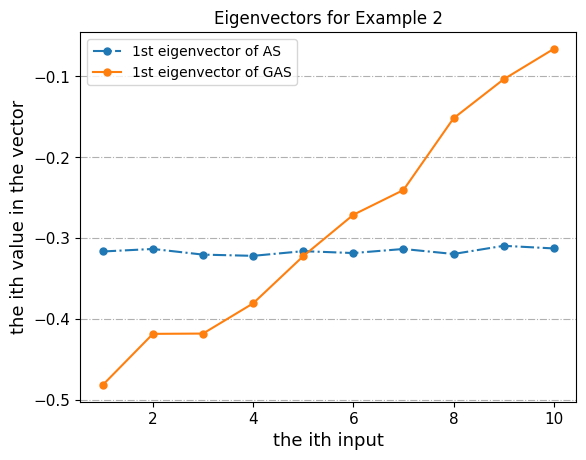

In [11]:
print(np.cumsum(s0)/np.sum(s0))
print(np.cumsum(s)/np.sum(s))

x=np.arange(1,1+10,1)
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
colorc=plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x,u0[:,0], label='1st eigenvector of AS', c=colorc[0], linestyle='-.', marker='.', markersize='10')
ax.plot(x,u[:,0], label='1st eigenvector of GAS', c=colorc[1], linestyle='-', marker='.', markersize='10')
ax.set_xlabel('the ith input', fontsize=13)
ax.set_ylabel('the ith value in the vector', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
plt.title('Eigenvectors for Example 2') 
plt.savefig(f'gas_paper/fcv_2.png')

In [ ]:
[9.00000000e-02 9.00000000e-01 
  ]

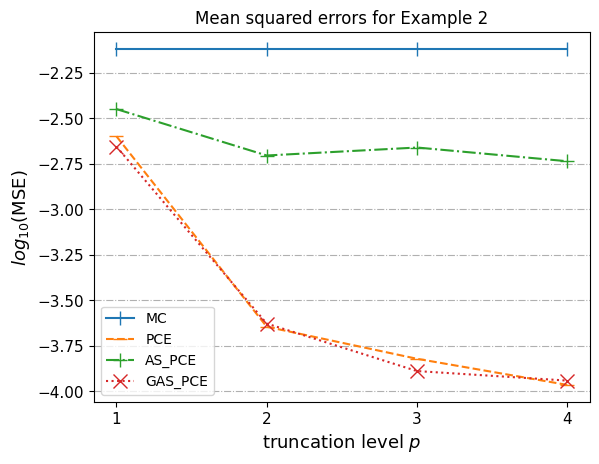

In [49]:
x=np.arange(1,5,1)
eMC = [0.00760662]*4#,7.75857391e-03,6.56614605e-03,4.98862620e-03]
ePCE = [0.00251828,2.26331707e-04,1.50876689e-04,1.08418158e-04]
ePCE_AS = [3.55302325e-03,1.97515286e-03,2.18495599e-03,1.83660535e-03]
ePCE_GAS = [2.21152343e-03,2.35566972e-04,1.29178217e-04,1.14503341e-04]

efMC = [1/(0.00760662*1.72982311)]*4 #[1/(0.00760662*1.72982311),1/(7.75857391e-03*1.85627341e+00),1/(6.56614605e-03*1.96044064e+00),1/(4.98862620e-03*1.77009034e+00)]
efPCE = [1/(0.00251828*2.29250932),1/(2.26331707e-04*5.28711891e+00),1/(1.50876689e-04*1.66162574e+01),1/(1.08418158e-04*6.10222406e+01)]
efPCE_AS = [1/(3.55302325e-03*4.41508412e+00 ),1/(1.97515286e-03*5.83770609e+00),1/(2.18495599e-03*3.66319418e+00),1/(1.83660535e-03*4.97823167e+00)]
efPCE_GAS = [1/(2.21152343e-03*5.85072732e+00),1/(2.35566972e-04* 7.40732813e+00),1/(1.29178217e-04*4.19085574e+00),1/(1.14503341e-04*5.14319468e+00)]

fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
ax.plot(x,np.log10(eMC), label='MC', linestyle='-', marker='|', markersize='10')
ax.plot(x,np.log10(ePCE), label='PCE', linestyle='--', marker='_', markersize='10')
ax.plot(x,np.log10(ePCE_AS), label='AS_PCE', linestyle='-.', marker='+', markersize='10')
ax.plot(x,np.log10(ePCE_GAS), label='GAS_PCE', linestyle=':', marker='x', markersize='10')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('truncation level $p$', fontsize=13)
ax.set_ylabel('$log_{10}$(MSE)', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')

legend = ax.legend(loc='best')
plt.title('Mean squared errors for Example 2') 
plt.savefig(f'gas_paper/2_mse.png')

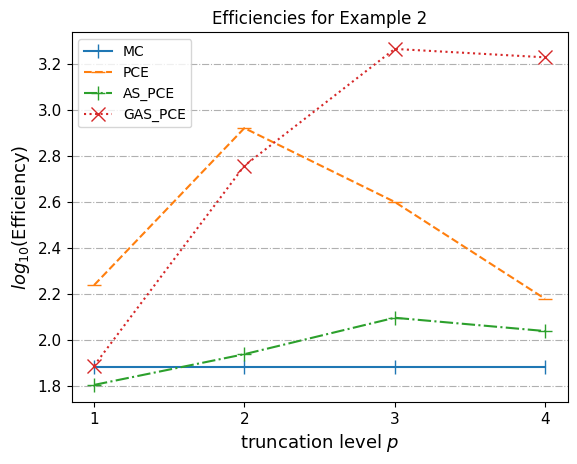

In [50]:
fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=100)
ax.plot(x,np.log10(efMC), label='MC', linestyle='-', marker='|', markersize='10')
ax.plot(x,np.log10(efPCE), label='PCE', linestyle='--', marker='_', markersize='10')
ax.plot(x,np.log10(efPCE_AS), label='AS_PCE', linestyle='-.', marker='+', markersize='10')
ax.plot(x,np.log10(efPCE_GAS), label='GAS_PCE', linestyle=':', marker='x', markersize='10')

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xlabel('truncation level $p$', fontsize=13)
ax.set_ylabel('$log_{10}$(Efficiency)', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.yaxis.grid(True, linestyle='-.')
legend = ax.legend(loc='best')
plt.title('Efficiencies for Example 2') 
plt.savefig(f'gas_paper/2_eff.png')

## MSE and efficiency heat maps

In [ ]:
adata = []
M2 = 5
S, r, V, kapa, theta = 100, 0.03, 0.025, 3, 0.025
for sigma in [0.01,0.05,0.1,0.15,0.2]:#
    for rho in [-0.99,-0.9,-0.5,0,0.5,0.9,0.99]:#
        dim = 10
        chi = 10000
        rho2 = np.sqrt(1-rho**2)
        realprice = 0
        for i in range(1):
            z3 = R.normal(0, 1, (1000000, dim))
            realprice += np.mean(Func(z3))
        realprice /= 1

        #AS
        epsilon = 0.01
        z = R.normal(0, 1, (chi, dim))
        start = time.time() 
        R.normal(0, 1, (chi, dim))
        deriv = dFunc(z)
        deriv /= np.mean(abs(deriv))
        u0, s0, vh0 = np.linalg.svd(deriv.astype(float), full_matrices=False) 
        s0 = s0**2
        print(sigma,rho,s0/sum(s0))
        print(u0[:,0])
        end = time.time()   
        time_as = end - start

        #GAS
        start = time.time() 
        u, s = global_as.GAS(Func,dim,chi,int(chi/M2),M2,shiftedSobol=True)
        fd_result = global_as_gaussian_quad.calculate_sensitivity_matrix(
            f=Func,
            X=R.normal(0, 1, (int(chi/2/M2), dim)),
            n_points=M2
        )
        s, u = np.linalg.eigh(fd_result.astype(float))  
        s = s[::-1]
        u = u[:, ::-1]
        # fd_result = global_as_gaussian_quad.calculate_ratio_matrix_mc(
        #     f=Func,
        #     X=R.normal(0, 1, (int(chi/2/M2), dim)),
        #     n_points=M2,
        #     min_dist = 0.01
        # )
        # u, s, _ = np.linalg.svd(fd_result.astype(float), full_matrices=False)  
        # s = s**2
        end = time.time()   
        M1p = 10000
        M2p = 10
        z = R.normal(0, 1, (M1p, dim))
        #lst = global_as.compute_C_u_1(z,Func,u,M2p)
        lst = global_as_gaussian_quad.calculate_gamma(
            f=Func,
            X=z,
            U=u,
            n_points=M2p
        )
        print(lst/sum(lst))
        print(u[:,0])
        time_gas = end - start

        ### Comparison
        N = 10000
        z0 = R.normal(0, 1, (N, dim))  
        z1 = []
        for i in range(40):
            z1.append(R.normal(0, 1, (N, dim)))
        Num_exp = 40

        #After Reduction
        p = 3
        dim = np.where((np.cumsum(s)/np.sum(s))>0.75)[0][0]+1
        P = int(comb(p + dim, dim))

        distribution = chaospy.J(chaospy.Normal(0, 1))
        for i in range(dim-1):
            distribution = chaospy.J(distribution, chaospy.Normal(0, 1))
        poly, norms = chaospy.generate_expansion(p, distribution, retall=True)
        normalized_coefficients = poly.coefficients/np.sqrt(norms)

        #AS_PCE and GAS_PCE
        PCE, PCE2 = np.zeros(Num_exp), np.zeros(Num_exp)
        times = np.zeros(3)

        times[0] += time_as
        start = time.time() 
        for i in range(Num_exp):           
            kii = estimate_k_reg0(z1[i][:,:dim],z1[i][:,dim:],poly.exponents,normalized_coefficients)
            PCE[i] = kii[0]
        end = time.time()
        times[0] += end - start

        times[1] += time_gas
        start = time.time() 
        PCE2 = global_as.GAS_PCE(Func, Num_exp, z1, dim, u, poly.exponents, normalized_coefficients, P)
        end = time.time()   
        times[1] += end - start     
        
        adata.append([sigma,rho,times[0],MSE(PCE),times[1],MSE(PCE2)])

0.01 -0.99 [0.97604901 0.00625513 0.00243887 0.00236308 0.00229481 0.0022291
 0.00218749 0.00217434 0.00204939 0.0019588 ]
[-0.49935974 -0.45314281 -0.40711257 -0.35812433 -0.30943907 -0.26315327
 -0.21159125 -0.16100314 -0.11055773 -0.05822124]


/Users/yrl192/Library/Python/3.9/lib/python/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


[9.99111402e-01 2.20500621e-04 1.98094928e-04 1.33024360e-04
 1.22781001e-04 7.90378813e-05 7.32102301e-05 3.49309604e-05
 2.11659246e-05 5.85177639e-06]
[0.50310773 0.44829794 0.40717163 0.35710685 0.31192962 0.26266916
 0.21363994 0.1604362  0.10924935 0.05463644]
0.01 -0.9 [0.838257   0.04130838 0.01675496 0.01611262 0.01535893 0.01492846
 0.01477793 0.01445265 0.01424259 0.0138065 ]
[-0.47746724 -0.43654964 -0.39874681 -0.35582615 -0.31964953 -0.27367087
 -0.2295283  -0.18685429 -0.14514952 -0.10050104]
[9.98902679e-01 2.80008491e-04 1.89311842e-04 1.52728313e-04
 1.23914792e-04 1.33424561e-04 8.87622256e-05 6.23230893e-05
 4.09894289e-05 2.58586610e-05]
[0.49538332 0.45637855 0.40693671 0.35828875 0.30960133 0.26343093
 0.2139303  0.16202883 0.10956057 0.05544179]
0.01 -0.5 [0.68527937 0.06622698 0.03433631 0.03229435 0.03172218 0.03110928
 0.03092712 0.02971312 0.02964626 0.02874503]
[-0.42903623 -0.40398676 -0.37361464 -0.3498812  -0.32321507 -0.29775794
 -0.26287892 -0.23741492

In [34]:
u,s,_ = np.linalg.svd(fd_result.astype(float))
print(u,s)

[[-5.09071174e-01  8.36737049e-01  1.79410391e-01 -7.04459200e-02
  -3.58871577e-02  1.66578165e-02 -3.04355975e-02  2.14839640e-02
  -7.50506710e-03 -2.36083001e-02]
 [-4.53760570e-01 -4.55753444e-01  7.35266016e-01 -1.77532251e-01
  -5.64098608e-02  8.30943196e-02 -5.46831338e-02  9.89104258e-03
   1.13683092e-02 -3.08589339e-02]
 [-4.03421714e-01 -1.93108206e-01 -5.56909211e-01 -6.74735399e-01
  -1.38232020e-01  1.03943167e-01 -2.87190899e-03  4.79191229e-02
   2.51043197e-02 -4.11997827e-02]
 [-3.58925094e-01 -1.51590950e-01 -2.49019105e-01  6.18907036e-01
  -5.54395987e-01  2.20027422e-01 -1.84729726e-01  1.00106968e-01
  -4.83442248e-02 -2.97642191e-02]
 [-3.08321780e-01 -1.03904651e-01 -1.81750510e-01  2.55126088e-01
   7.90483603e-01  3.79141271e-01 -1.39732549e-01  3.17875293e-03
  -3.25052141e-02  8.25507422e-02]
 [-2.58331666e-01 -1.15988698e-01 -1.08289755e-01  1.33173237e-01
   1.92655734e-01 -8.34951902e-01 -1.58052255e-01  3.14892231e-01
  -1.43237429e-01 -1.06930291e-01

In [48]:
adata = np.array(adata)
asEff = 1/(adata[:,2]*adata[:,3])
gasEff = 1/(adata[:,4]*adata[:,5])
errRatio = adata[:,5]/adata[:,3]
effRatio = gasEff/asEff

In [27]:
adata[:,5].reshape((5,7))

array([[8.80052759e-05, 8.13412252e-05, 1.57001437e-04, 1.49001237e-04,
        1.44617930e-04, 1.50125346e-04, 1.33194257e-04],
       [1.26468627e-04, 1.65337014e-04, 1.76534534e-03, 1.43135943e-03,
        8.13816752e-04, 9.65726179e-05, 1.21673258e-04],
       [1.47655575e-04, 5.16138798e-04, 1.57964090e-03, 1.57897195e-03,
        1.82875751e-03, 1.91934611e-04, 1.34267390e-04],
       [6.00072235e-04, 1.48187219e-03, 3.97035966e-04, 2.19423836e-03,
        9.64592602e-04, 8.60338833e-04, 1.95159814e-04],
       [6.68503042e-04, 6.64993167e-04, 1.43034832e-03, 2.40985174e-03,
        1.89469648e-03, 6.63820322e-04, 6.58966061e-04]])

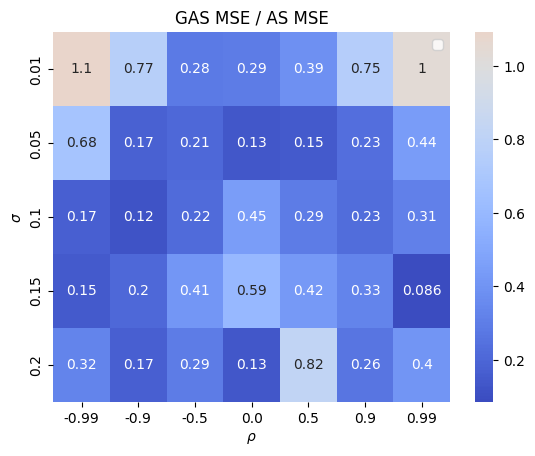

In [49]:
er = errRatio.reshape((5,7))
df = pd.DataFrame(er,columns=adata[:,1].reshape((5,7))[0,:],index=adata[:,0].reshape((5,7))[:,0])
sns.heatmap(df,cmap='coolwarm',annot=True,center = 1)
plt.title('GAS MSE / AS MSE')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\sigma$')
plt.legend()
#plt.show() 
plt.savefig(f'gas_paper/qmc{M2}_1.png')

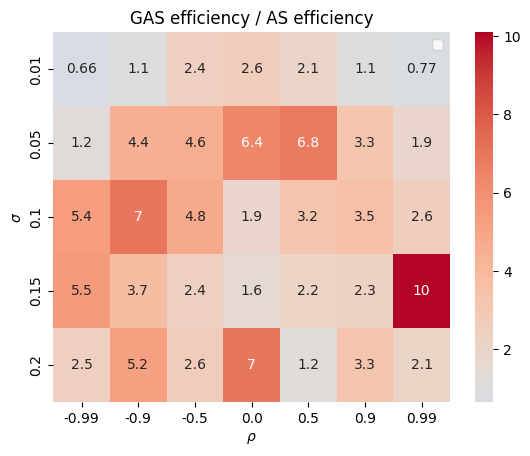

In [50]:
er = effRatio.reshape((5,7))
df = pd.DataFrame(er,columns=adata[:,1].reshape((5,7))[0,:],index=adata[:,0].reshape((5,7))[:,0])
sns.heatmap(df,cmap='coolwarm',annot=True,center = 1)
plt.title('GAS efficiency / AS efficiency')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\sigma$')
plt.legend()
#plt.show() 
plt.savefig(f'gas_paper/qmc{M2}_2.png')